In [1]:
import pandas as pd
from datetime import datetime

weather_data_filepath = "data/weather_data.csv"
electricity_data_filepath = "data/electricity_production_data.csv"

df_weather = pd.read_csv(weather_data_filepath, delimiter=',')
df_electricity = pd.read_csv(electricity_data_filepath, delimiter=',')

df_weather['time'] = pd.to_datetime(df_weather['referenceTime'])
df_weather['time'] = df_weather['time'].dt.tz_localize(None)
df_electricity['time'] = pd.to_datetime(df_electricity['måned'], format='%YM%m')
df_weather = df_weather.drop(columns="referenceTime")
df_electricity = df_electricity.drop(columns="måned")

df_weather['month_year'] = df_weather['time'].dt.strftime('%Y-%m')
df_electricity['month_year'] = df_electricity['time'].dt.strftime('%Y-%m')

df_merged = pd.merge(df_weather.drop(columns="time"), df_electricity.drop(columns="time"), on="month_year", suffixes=["_precipitation", "_electricity"], how="outer")
df_merged.sort_values(by='month_year', inplace=True)

def get_cropped_df(df, start_year, end_year):
    df['month_year'] = pd.to_datetime(df['month_year'], format='%Y-%m')
    cropped_df_merged = df[(df['month_year'].dt.year >= start_year) & (df['month_year'].dt.year <= end_year)]
    cropped_df_merged.reset_index(drop=True, inplace=True)
    return cropped_df_merged

df_merged_all_values = df_merged.dropna()
df_merged_all_values['month_year'] = pd.to_datetime(df_merged_all_values['month_year'])
df_merged_all_values.set_index('month_year', inplace=True)


/var/folders/d7/j_29bjyn0_lbt66yfhsy0pf00000gp/T/ipykernel_35810/176743871.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_all_values['month_year'] = pd.to_datetime(df_merged_all_values['month_year'])


In [50]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

#-----------PARAMS--------------#
AR_LAG = 2
MA_LAG = 1
DIFFERENCING = 0
order=(AR_LAG,DIFFERENCING,MA_LAG)
exog=df_merged_all_values['value_precipitation']
TEST_SIZE = 12
# params = {'order': order, 'exog': exog.iloc[0:-TEST_SIZE]}
params = {'order': order, 'exog': exog}
#################################


# model = ARIMA(df_merged_all_values['value_electricity'].iloc[0:-TEST_SIZE], **params)
model = ARIMA(df_merged_all_values['value_electricity'], **params)
model_fit = model.fit()

/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/almax/Documents/NTNU/24h/time_series/ntnu-time-series/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

In [51]:
# This must be changed manually according to TEST_SIZE
# E.g. last 24 months is 2010-2011
forecast_weather_data = get_cropped_df(df_merged, 2012, 2013)['value_precipitation']

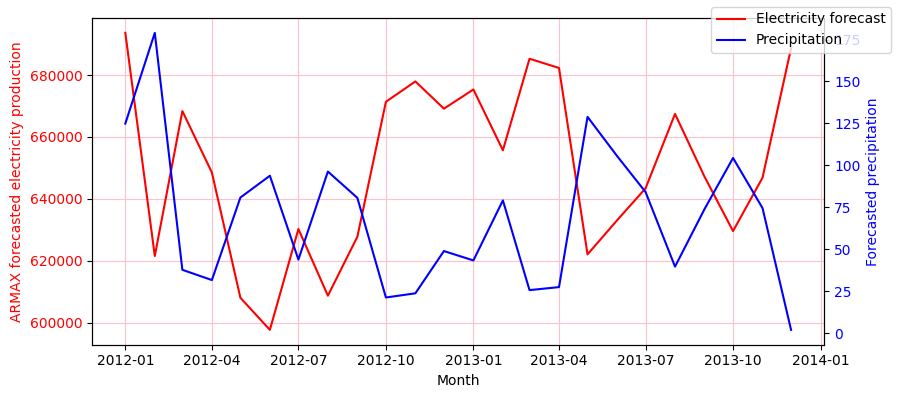

In [72]:

# forecast = model_fit.forecast(steps=TEST_SIZE, exog=forecast_weather_data)
forecast = model_fit.forecast(steps=24, exog=forecast_weather_data)

fig, ax1 = plt.subplots(figsize=(9,4))
ax1.set_xlabel("Month")
ax1.plot(forecast, label="Electricity forecast", color="red")
ax1.set_ylabel("ARMAX forecasted electricity production", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.grid(color="pink")
forecast_weather_data.index = forecast.index
# plt.figure(figsize=(12,6))
ax2 = ax1.twinx()
ax2.plot(forecast_weather_data, label="Precipitation", color="blue")
ax2.set_ylabel("Forecasted precipitation", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# plt.plot(df_merged_all_values['value_electricity'].iloc[-TEST_SIZE:], label="Real data")
fig.tight_layout()
fig.legend()
plt.show()

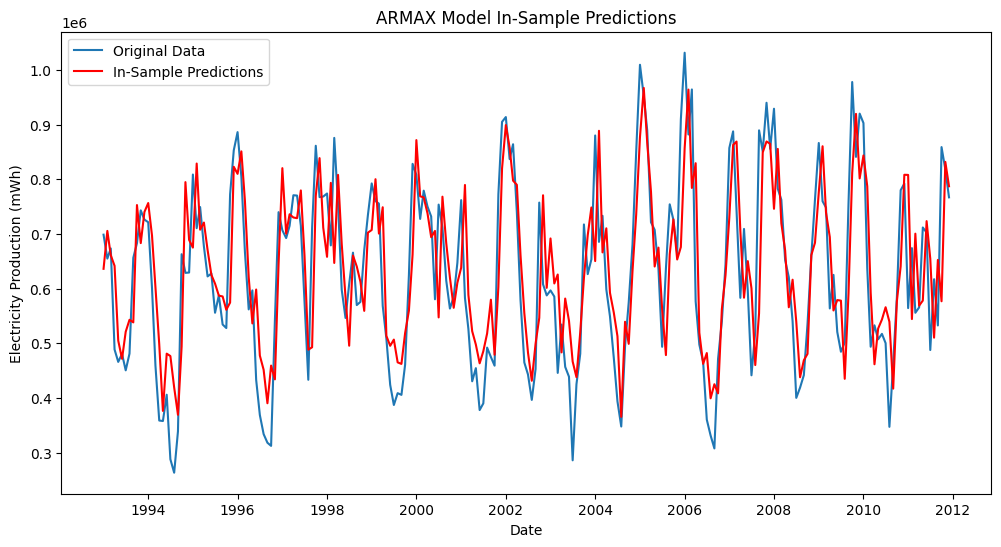

In [ ]:

in_sample_predictions = model_fit.predict(start=0, end=len(df_merged_all_values)-1, dynamic=False)
# Plot the original data and the in-sample predictions
plt.figure(figsize=(12, 6))
plt.plot(df_merged_all_values['value_electricity'], label='Original Data')
plt.plot(in_sample_predictions, label='In-Sample Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Production (mWh)')
plt.title('ARMAX Model In-Sample Predictions')
plt.legend()
plt.show()

In [4]:
from sklearn.metrics import mean_squared_error
from math import sqrt

X = df_merged_all_values['value_electricity'].values

TRAIN_SIZE = 0.8
train_size = int(len(X)*TRAIN_SIZE)
train, test = X[0:train_size], X[train_size:len(X)]
history = [x for x in train]
preds = list()

for t in range(len(test)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"predicted={yhat}, expected={obs}")

rmse = sqrt(mean_squared_error(test, preds))
print('Test RMSE: %.3f' % rmse)

predicted=676192.009295492, expected=762680.0
predicted=668506.4737030093, expected=652405.0
predicted=579242.9102668989, expected=621000.0
predicted=570765.1004414517, expected=540318.0
predicted=515611.2865970529, expected=399981.0
predicted=411023.9454511477, expected=418737.0
predicted=458243.8036398189, expected=441643.0
predicted=497307.7181020795, expected=535632.0
predicted=591194.107620839, expected=659593.0
predicted=697457.2485860428, expected=763195.0
predicted=772065.5194534503, expected=866552.0
predicted=839738.183174729, expected=759839.0
predicted=714729.225325343, expected=748445.0
predicted=697498.157988125, expected=563715.0
predicted=529929.5902768194, expected=625160.0
predicted=604724.8693878931, expected=520705.0
predicted=518985.76288150385, expected=484406.0
predicted=503794.41643266845, expected=501368.0
predicted=534756.9822045786, expected=756721.0
predicted=768732.9536305079, expected=978172.0
predicted=942866.1311501309, expected=841124.0
predicted=772581

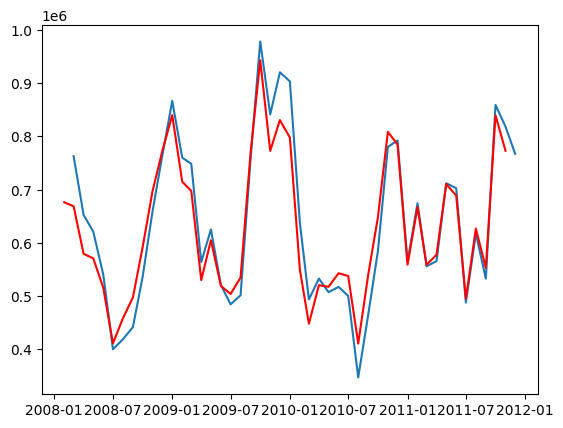

In [9]:
# plot forecasts against actual outcomes
plt.plot(df_merged_all_values.iloc[train_size:len(X)].index, test)
plt.plot(df_merged_all_values.iloc[train_size-1:len(X)-1].index, preds, color='red')
plt.show()

In [6]:
FORECAST_STEPS = 24
forecast = model_fit.forecast(steps=FORECAST_STEPS)

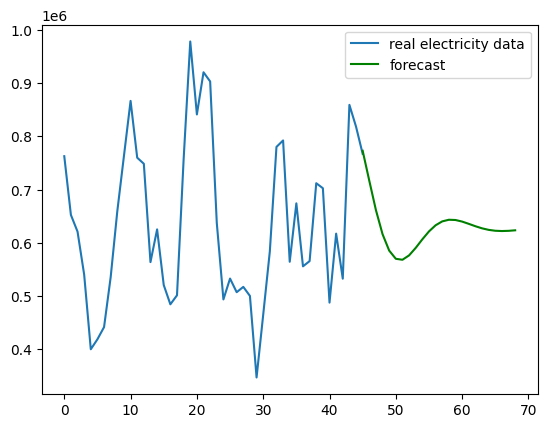

In [10]:
plt.plot(test, label="real electricity data")
plt.plot(range(len(test)-1, len(test)+FORECAST_STEPS-1),forecast, color='green', label="forecast")
plt.legend()
plt.show()